# 프로젝트 : 다양한 OCR모델 비교하기

## 검증용 데이터셋 준비

glob이용해서 jpg를 모두 열기

In [9]:
from glob import glob
import tensorflow as tf
import os

In [10]:
Root = os.getenv('HOME')+'/aiffel/ocr_python/'
train_set = tf.io.gfile.glob(str(Root+'*.jpg'))

In [11]:
train_set

['/home/ssac26/aiffel/ocr_python/dream-4827288_640.jpg',
 '/home/ssac26/aiffel/ocr_python/blue-1845901_640.jpg',
 '/home/ssac26/aiffel/ocr_python/signs-381046_640.jpg',
 '/home/ssac26/aiffel/ocr_python/signs-820614_640.jpg',
 '/home/ssac26/aiffel/ocr_python/route-66-1264292_640.jpg',
 '/home/ssac26/aiffel/ocr_python/thiebaud-faix-eBkEJ9cH5b4-unsplash.jpg',
 '/home/ssac26/aiffel/ocr_python/signs-2799416_640.jpg',
 '/home/ssac26/aiffel/ocr_python/make-the-day-great-4166221_640.jpg',
 '/home/ssac26/aiffel/ocr_python/book-912725_640.jpg',
 '/home/ssac26/aiffel/ocr_python/accounts-1238594_640.jpg']

## Google OCR API, keras-ocr, Tesseract로 테스트 진행

### Google API

In [9]:
'''구글의 파이썬 API 인터페이스 모듈을 설치  
# pip install --upgrade google-api-python-client
# pip install google-cloud-vision

# Google Cloud Vision API 사용
# cp ~/Downloads/sheet-contents-xxxx.json ~/aiffel/ocr_python/my_google_api_key.json

# 인증키 경로 등록 후 커널 재기동
# export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json

# 한번등록후 계속 사용하고 싶을시
# echo "export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json" >> ~/.bashrc'''

'구글의 파이썬 API 인터페이스 모듈을 설치  \n# pip install --upgrade google-api-python-client\n# pip install google-cloud-vision\n\n# Google Cloud Vision API 사용\n# cp ~/Downloads/sheet-contents-xxxx.json ~/aiffel/ocr_python/my_google_api_key.json\n\n# 인증키 경로 등록 후 커널 재기동\n# export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json\n\n# 한번등록후 계속 사용하고 싶을시\n# echo "export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json" >> ~/.bashrc'

In [10]:
from google.cloud import vision
import io

def detect_text(path):
    """Detects text in the file."""
    
    client = vision.ImageAnnotatorClient()
    # 바이너리 파일 읽기위해 rb모드로
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [12]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.jpeg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-r--r-- 1 ssac26 ssac26 2329  3월 17 13:46 /home/ssac26/aiffel/ocr_python/my_google_api_key.json


PermissionDenied: 403 This API method requires billing to be enabled. Please enable billing on project #591808322595 by visiting https://console.developers.google.com/billing/enable?project=591808322595 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry.

구글 API결제 오류로 사용불가

### keras-ocr

In [4]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()


Looking for /home/ssac26/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/ssac26/.keras-ocr/crnn_kurapan.h5


In [6]:
#train_set >>some jpg

images = [ keras_ocr.tools.read(img) for img in train_set]
prediction_groups = [pipeline.recognize([img]) for img in train_set]

In [9]:
len(images)

10

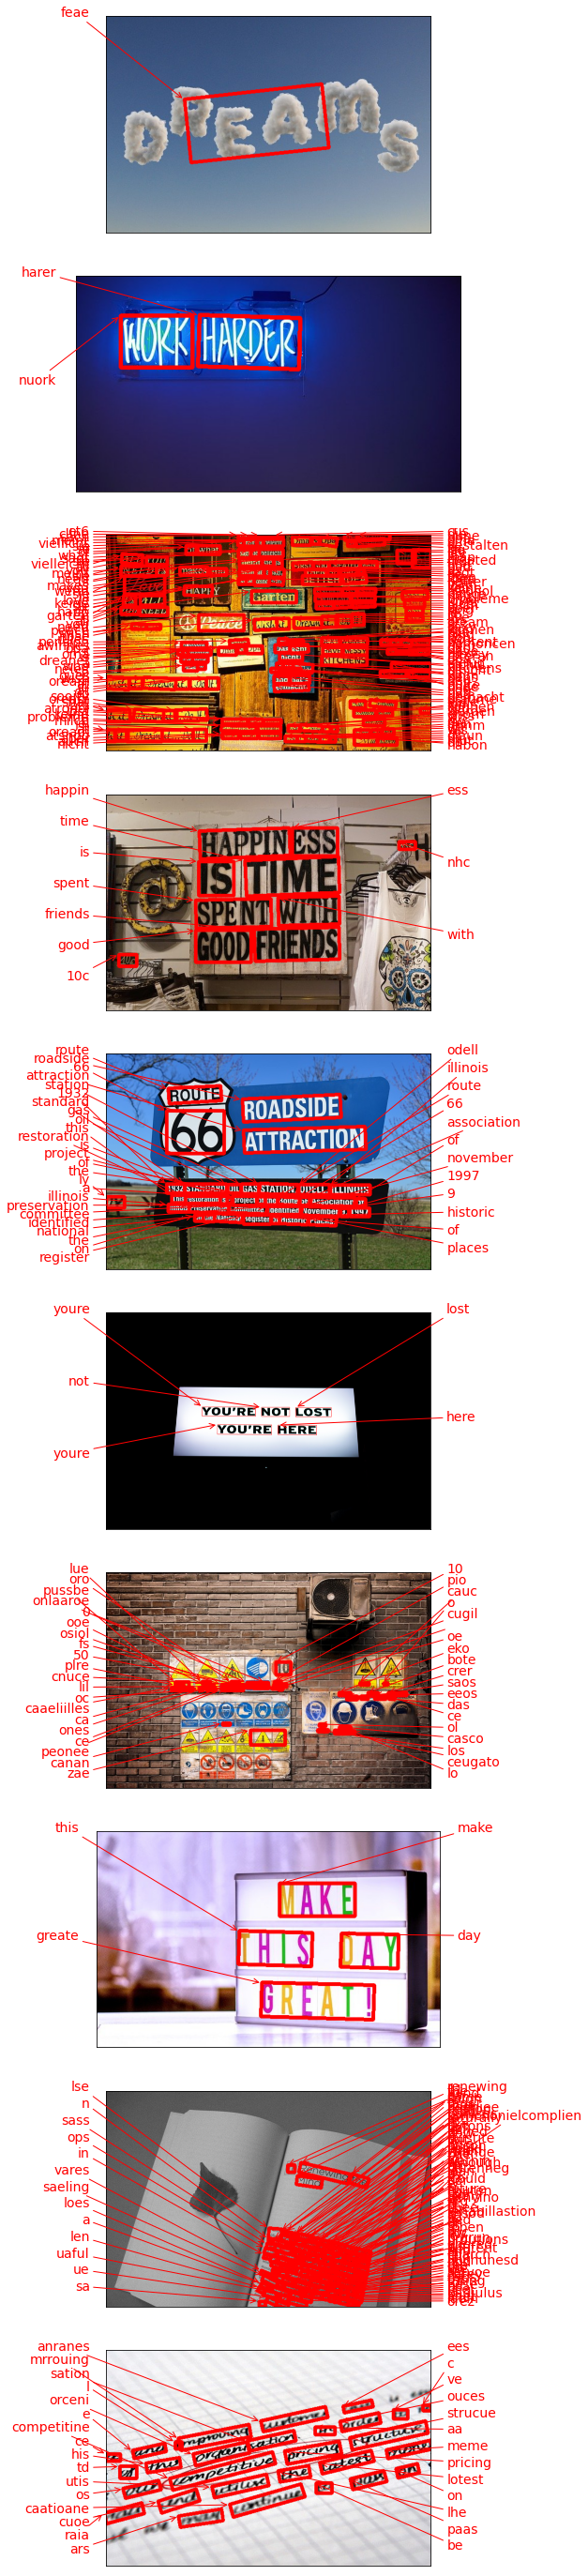

In [13]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)


### Tesseract - 구글에서 후원하는 OCR 오픈소스 라이브러리

In [14]:
# 테서랙트 설치하기
# $ sudo apt install tesseract-ocr
# $ sudo apt install libtesseract-dev

# 테서랙트 파이썬 wrapper 설치하기

# $ pip install pytesseract

* 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [30]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            # print(output_img_path)
            
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    print('----------')
    print(len(cropped_image_path_list))
    return cropped_image_path_list




----------
6


* 테서랙트로 잘린 이미지에서 단어 인식하기

In [31]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
       # warebox = []
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
       # warebox.append(recognized_data['text'])
        print(recognized_data['text'],end="")
    print("Done")

----------
1
Done


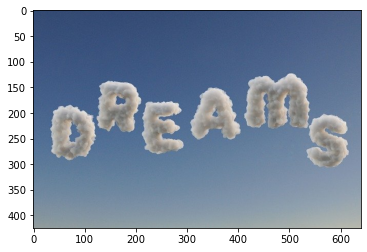

In [38]:
# test

import cv2
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/dream-4827288_640.jpg' 
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
# fig, axs = plt.subplots(nrows=len(images), figsize=(50, 50))
sample = cv2.imread(img_file_path)
sample = cv2.cvtColor(sample,cv2.COLOR_BGR2RGB)
plt.imshow(sample)
recognize_images(cropped_image_path_list)



In [33]:
train_set

['/home/ssac26/aiffel/ocr_python/dream-4827288_640.jpg',
 '/home/ssac26/aiffel/ocr_python/blue-1845901_640.jpg',
 '/home/ssac26/aiffel/ocr_python/signs-381046_640.jpg',
 '/home/ssac26/aiffel/ocr_python/signs-820614_640.jpg',
 '/home/ssac26/aiffel/ocr_python/route-66-1264292_640.jpg',
 '/home/ssac26/aiffel/ocr_python/thiebaud-faix-eBkEJ9cH5b4-unsplash.jpg',
 '/home/ssac26/aiffel/ocr_python/signs-2799416_640.jpg',
 '/home/ssac26/aiffel/ocr_python/make-the-day-great-4166221_640.jpg',
 '/home/ssac26/aiffel/ocr_python/book-912725_640.jpg',
 '/home/ssac26/aiffel/ocr_python/accounts-1238594_640.jpg']

----------
1
Done


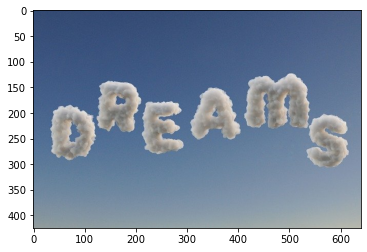

----------
1
Daud
Done


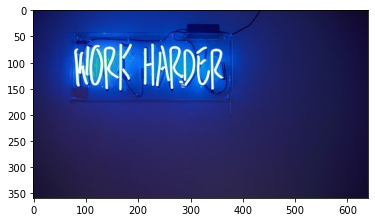

----------
14
Tes eae
NEED IS makes you | inn eee a
Sa
sie viewleicnt.
SSCS ae
,
TTyTe
i i
RST GOD CR
FATED MAN |
VU
pay
Done


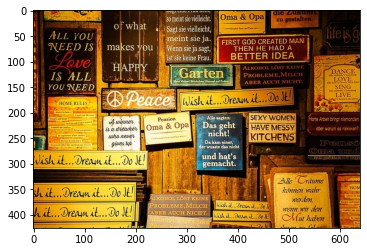

----------
1
Done


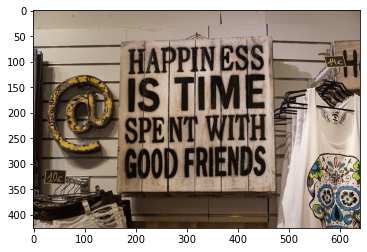

----------
47
d
,
~~  e)
. Yo >
Pi
ene
AR
SIANDAR
pau
STATION,
Uses
ILLINOIS
This
restoration
1S
yt
i
the
houte
ae
Association
Hi
iiiinois Pr
SAM EMM Mets
iste tet mA
ovempber
. F
1997
L
imtils
National
Registe
Qi)
Historic
gclinhice
|
66
Na Te
VY Nj
on
Mt cits
Done


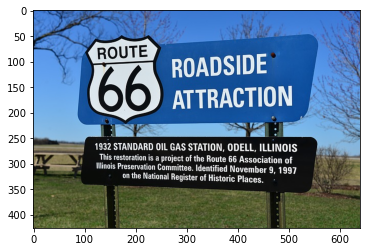

----------
6
YOU'RE
NOT
LOST
YOU'RE
SeRE
Done


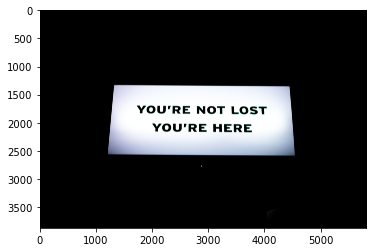

----------
4
ee a we
ce a eee eeeeEEEEeEeEeEeEeEeEeEeEeEeEEeEeE
Done


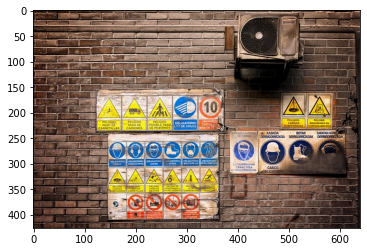

----------
1
Done


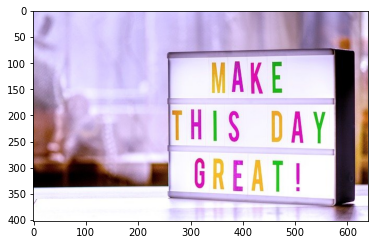

----------
1
Done


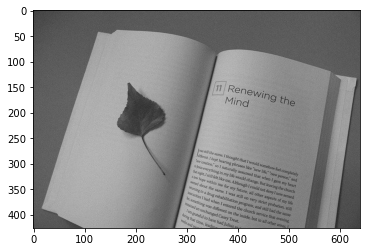

----------
1
Done


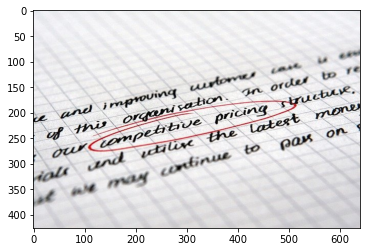

In [37]:
for i in train_set:
    # print(i)
    cropped_image_path_list2 = crop_word_regions(i, work_dir)
    sample = cv2.imread(i)
    sample = cv2.cvtColor(sample,cv2.COLOR_BGR2RGB)
    plt.imshow(sample)
    recognize_images(cropped_image_path_list2)
    plt.show()
    

In [ ]:
'''
직접 모델을 생성하는 것이 아닌 API를 사용했지만,구글API는 결제상의 문제로 사용불가,
테서렉트는 검은색 자판으로 된 글씨1개만 인식하는데 성공했으며 그도 완전히 인식하지 못했다.
keras-ocr의 경우 페이지 내의 많은 텍스트도 잘 인식했고, 필기체도 인식에 성공했다. 약간의 단어를 잘못인식하긴 했지만 나름 만족스러운 성능같다.
구글어플리케이션에 렌즈라는 휴대폰 카메라로 촬영되는 문자를 실시간으로 언어도 자동으로 체크하여 번역해주는 서비스가 있다. 직접 API들을 사용해보니
렌즈의 높은 성능에 놀라게된다.'''